# Cat and Dog Classifier Using Convolutional Neural Networks (CNNs)

## Introduction

This project focuses on building a Convolutional Neural Network (CNN) to classify images of cats and dogs. CNNs are a specialized type of artificial neural network, designed specifically for image recognition and processing tasks. Their architecture is inspired by the structure of the visual cortex, making them highly effective for extracting spatial and hierarchical features from images.

### Objectives

- To preprocess a dataset of cat and dog images for training.
- To design and train a CNN model to accurately classify images as either a "cat" or a "dog."
- To evaluate the model's performance using metrics like accuracy and loss.
- To test the classifier on unseen images to measure generalization.


### Dataset

We will use a publicly available dataset of labeled cat and dog images. The dataset will be split into training, validation, and testing subsets to ensure robust model evaluation.

### Tools and Libraries

This project leverages Python and the following libraries:
- **TensorFlow/Keras**: For building and training the CNN model.
- **NumPy**: For numerical computations.
- **Matplotlib**: For visualizing data and training performance.
- **OpenCV or PIL**: For image preprocessing and augmentation.

By the end of this project, we aim to create a model capable of achieving high accuracy in distinguishing cats from dogs and gain insights into the capabilities of CNNs for image classification tasks.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,Input
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Dataset Generators

In this section, we create training and validation datasets using the `keras.utils.image_dataset_from_directory` function. This method efficiently loads and preprocesses image data directly from directories.

### Training Dataset

The training dataset is created by specifying the path to the directory containing training images. The labels are inferred automatically from the folder names (e.g., "cats" and "dogs"). Images are grouped into batches of 32, resized to 256x256 pixels, and labeled as integers (`0` for "cat" and `1` for "dog"). 

This dataset will be used to train the model and adjust the weights based on the backpropagation algorithm.

### Validation Dataset

The validation dataset is generated similarly, but it uses images from a separate directory containing testing data. One key difference is that shuffling is disabled in the validation set to ensure that the evaluation process is consistent and reproducible. Like the training dataset, validation images are also resized to 256x256 pixels and batched into groups of 32.

### Advantages of Using Generators

1. **Memory Efficiency**: By loading images in batches, the generator avoids loading the entire dataset into memory at once, which is crucial for large datasets.
2. **Automatic Label Inference**: Labels are derived directly from folder names, reducing manual preprocessing efforts.
3. **Built-in Preprocessing**: Images are resized to the required dimensions during loading, simplifying the preparation pipeline.



In [2]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dogs-vs-cats/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False  # Disable shuffling
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


### Normalization

Normalization is an essential preprocessing step in image classification tasks. It involves scaling pixel values to a specific range, typically [0, 1]. This helps in:

1. **Improving Model Training:**
   - Normalized inputs lead to faster convergence during training, as the model's weights are updated more smoothly.

2. **Ensuring Consistent Input:**
   - Scaling pixel values ensures that the input data has consistent range and distribution, which helps in stabilizing the learning process.

In our dataset, we normalize the images by dividing pixel values by 255. This scales the values from the range [0, 255] to [0, 1].


In [3]:
# Normalize
def normalization(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalization)
validation_ds = validation_ds.map(normalization)

## Visualizing the Dataset

To better understand the dataset, it is important to visualize some of the images along with their labels. The provided code achieves this by using the `plot_images` function and `matplotlib` for plotting.

1. **Training Dataset Visualization**:
   - The `plot_images(train_ds)` call visualizes images from the training dataset. This allows us to check the quality, size, and diversity of the training data.

2. **Validation Dataset Visualization**:
   - The `plot_images(validation_ds)` call visualizes images from the validation dataset. This ensures that the validation data is consistent with the training data in terms of format and content.

### Purpose of Visualization

- **Verify Dataset Integrity**: Confirm that the images are correctly labeled and properly loaded into the dataset.
- **Check Preprocessing**: Ensure that the resizing and format conversion steps have been applied correctly.
- **Understand Data Distribution**: Gain insights into the diversity of images within the training and validation sets.


In [4]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("float32"))
            plt.title('Dog' if labels[i] == 1 else 'Cat')
            plt.axis("off")


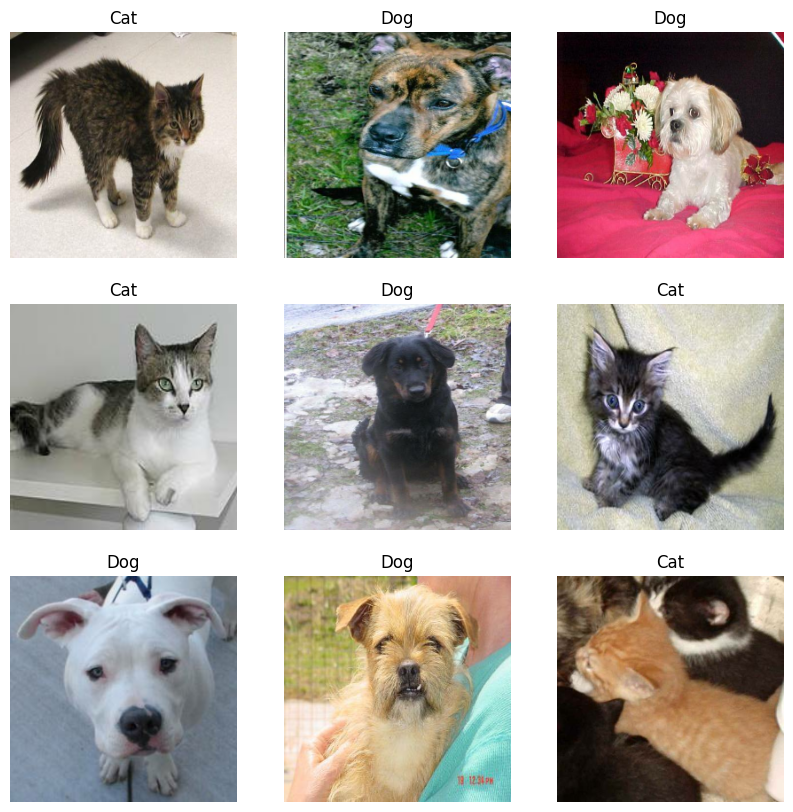

In [5]:
# Plot some training images
plot_images(train_ds)


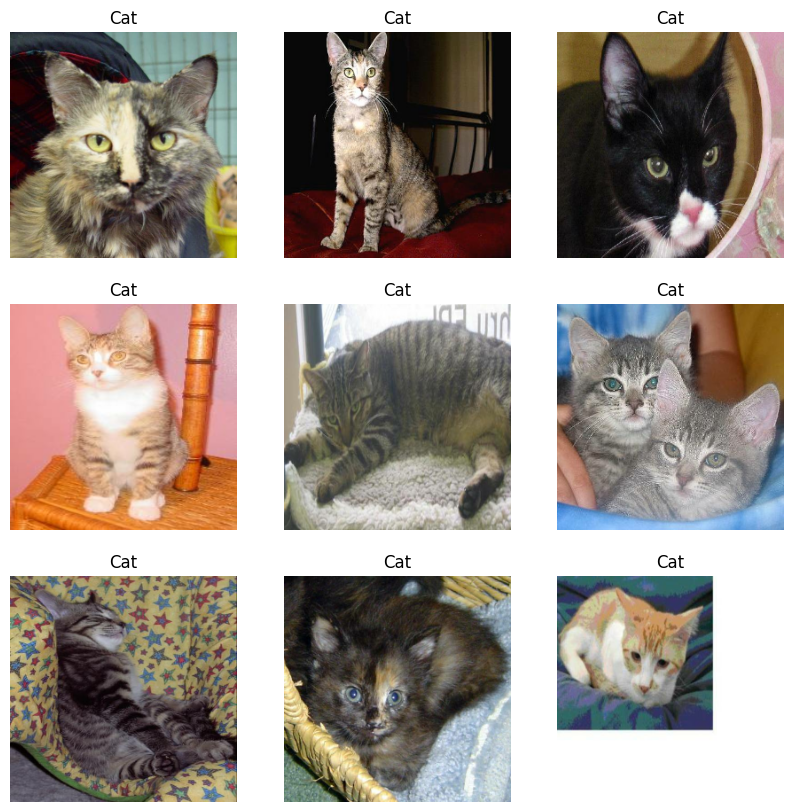

In [6]:
# Plot some validation images
plot_images(validation_ds)

### Checking Class Distribution

When working with machine learning models, especially in classification tasks, it is crucial to understand the distribution of classes in your dataset. Here are the key reasons for checking the class distribution:

1. **Identify Class Imbalance:**
   - Class imbalance occurs when one class is significantly more frequent than the others. This can lead to biased models that favor the majority class and result in poor performance on the minority class.
   - By checking the class distribution, we can identify any imbalance and take corrective measures such as resampling (oversampling or undersampling), using class weights, or employing advanced techniques like Synthetic Minority Over-sampling Technique (SMOTE).

2. **Ensure Fair Evaluation:**
   - Knowing the class distribution helps in selecting appropriate evaluation metrics. For imbalanced datasets, metrics like accuracy might be misleading. Instead, metrics like precision, recall, F1-score, and the area under the ROC curve (AUC-ROC) are more informative.

3. **Improve Model Training:**
   - Balanced datasets generally lead to better model training. If the classes are balanced, the model can learn equally from all classes, leading to more robust and generalized predictions.


Training set class distribution: {0: 10000, 1: 10000}
Validation set class distribution: {0: 2500, 1: 2500}


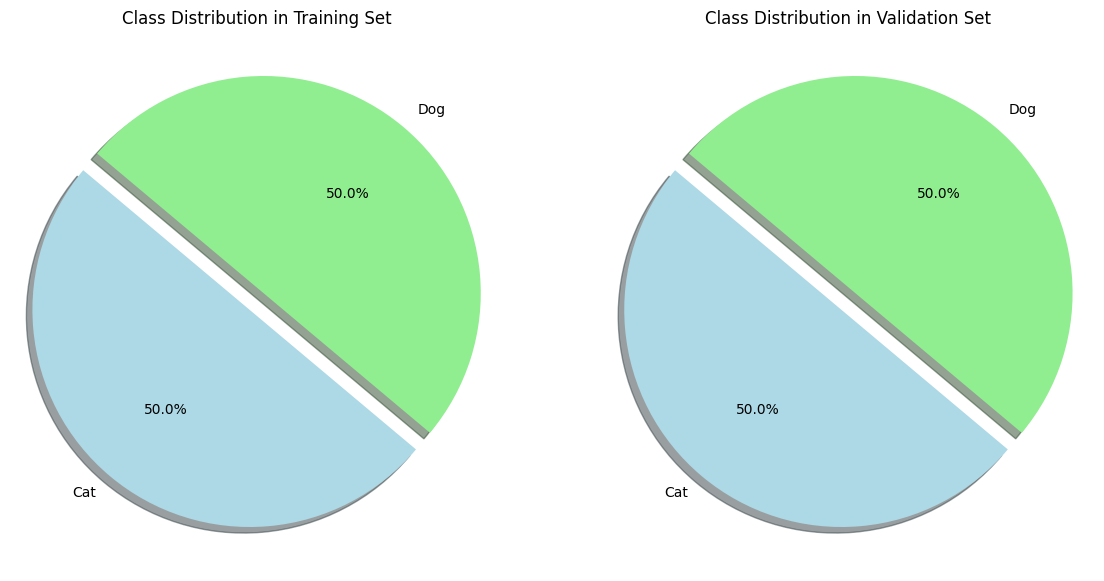

In [7]:
import matplotlib.pyplot as plt

# Function to count class distribution
def count_class_distribution(dataset):
    class_counts = {0: 0, 1: 0}
    for images, labels in dataset:
        for label in labels:
            class_counts[int(label)] += 1
    return class_counts

# Count distribution in training and validation sets
train_class_distribution = count_class_distribution(train_ds)
validation_class_distribution = count_class_distribution(validation_ds)

# Count distribution in training set
train_class_distribution = count_class_distribution(train_ds)
print(f"Training set class distribution: {train_class_distribution}")

# Count distribution in validation set
validation_class_distribution = count_class_distribution(validation_ds)
print(f"Validation set class distribution: {validation_class_distribution}")

# Data for the pie charts
labels = ['Cat', 'Dog']
train_sizes = [train_class_distribution[0], train_class_distribution[1]]
validation_sizes = [validation_class_distribution[0], validation_class_distribution[1]]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode 1st slice (Cat)

# Plotting side by side pie charts
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Training set pie chart
ax[0].pie(train_sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
          shadow=True, startangle=140)
ax[0].set_title('Class Distribution in Training Set')
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Validation set pie chart
ax[1].pie(validation_sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
          shadow=True, startangle=140)
ax[1].set_title('Class Distribution in Validation Set')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Class Distribution in Our Dataset

In our case, we are using the "Dogs vs. Cats" dataset from Kaggle. We checked the class distribution in both the training and validation datasets to ensure they are balanced. Here is the distribution:

- **Training Set:**
  - Cats: 50%
  - Dogs: 50%

- **Validation Set:**
  - Cats: 50%
  - Dogs: 50%

The equal distribution of classes (50% Cats and 50% Dogs) indicates that our dataset is balanced. This balance is ideal for training our Convolutional Neural Network (CNN) model, as it allows the model to learn equally from both classes, leading to better performance and fair evaluation.

### Visualization of Class Distribution

To visualize the class distribution, we plotted pie charts for both the training and validation datasets side by side. This visual representation helps us quickly understand the balance of classes in our dataset.


-------------

### Model Architecture

We have designed a Convolutional Neural Network (CNN) model for the "Dogs vs. Cats" classification task. The model consists of the following layers:

1. **Input Layer:**
   - The input shape is (256, 256, 3), which corresponds to 256x256 RGB images.

2. **First Convolutional Block:**
   - Two Conv2D layers with 32 filters and a kernel size of (3, 3), each followed by BatchNormalization and ReLU activation.
   - MaxPooling2D layer with a pool size of (2, 2).
   - Dropout layer with a rate of 0.2 to prevent overfitting.

3. **Second Convolutional Block:**
   - Two Conv2D layers with 64 filters and a kernel size of (3, 3), each followed by BatchNormalization and ReLU activation.
   - MaxPooling2D layer with a pool size of (2, 2).
   - Dropout layer with a rate of 0.3 to prevent overfitting.

4. **Third Convolutional Block:**
   - Two Conv2D layers with 128 filters and a kernel size of (3, 3), each followed by BatchNormalization and ReLU activation.
   - MaxPooling2D layer with a pool size of (2, 2).
   - Dropout layer with a rate of 0.4 to prevent overfitting.

5. **Fourth Convolutional Block:**
   - Two Conv2D layers with 256 filters and a kernel size of (3, 3), each followed by BatchNormalization and ReLU activation.
   - MaxPooling2D layer with a pool size of (2, 2).
   - Dropout layer with a rate of 0.5 to prevent overfitting.

6. **Fully Connected Layers:**
   - Flatten layer to convert the 2D matrix to a 1D vector.
   - Dense layer with 128 units and ReLU activation.
   - Dropout layer with a rate of 0.5 to prevent overfitting.
   - Output Dense layer with 1 unit and sigmoid activation for binary classification.


In [8]:
# Initialize a Sequential model
model = Sequential()

# Add the Input layer
model.add(Input(shape=(256, 256, 3)))

# First Convolutional Block
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


# Second Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Convolutional Block
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Additional dense layer
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))


# Display the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 252, 252, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 122, 122, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 59, 59, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 57, 57, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 57, 57, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,894,945 (22.49 MB)

 Trainable params: 5,893,025 (22.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

-------------

## Configuring Callbacks and Compiling the Model

In this section, we configure callbacks to improve training performance and compile the model with the appropriate optimizer, loss function, and evaluation metrics.


- **ReduceLROnPlateau** improves convergence by adjusting the learning rate dynamically.
- **EarlyStopping** avoids overfitting and saves time by stopping training when improvements plateau.
- **ModelCheckpoint** ensures the best model is preserved.
- The model is compiled with `adam` optimizer, `binary_crossentropy` loss, and accuracy as the evaluation metric.


In [9]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


In [11]:
history = model.fit(train_ds,
                    epochs=100,batch_size=32,validation_data=validation_ds,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5741 - loss: 2.4284
Epoch 1: val_accuracy improved from -inf to 0.58580, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 202ms/step - accuracy: 0.5742 - loss: 2.4264 - val_accuracy: 0.5858 - val_loss: 0.9204 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6791 - loss: 0.6808
Epoch 2: val_accuracy improved from 0.58580 to 0.75640, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 191ms/step - accuracy: 0.6791 - loss: 0.6808 - val_accuracy: 0.7564 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7474 - loss: 0.6001
Epoch 3: val_accuracy did not improve from 0.75640
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 191ms/step - accuracy: 0.7474 - loss: 0.6001 - val_accuracy: 0.7146 - val_loss: 0.6713 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.791

## Purpose of the Code

The code visualizes the training history of the model to analyze its performance over epochs by plotting:

1. **Training and Validation Loss**:
   - Helps identify if the model is learning effectively or overfitting.

2. **Training and Validation Accuracy**:
   - Tracks improvements in model accuracy and highlights potential gaps between training and validation performance.

### Key Features
- Two side-by-side plots:
  - **Loss**: Tracks both training and validation loss.
  - **Accuracy**: Tracks both training and validation accuracy.
- Clear labeling and legends for easy interpretation.

### Outcome
- Understand trends in learning, overfitting, or underfitting.
- Make informed decisions to improve model performance (e.g., adjusting epochs, adding regularization).


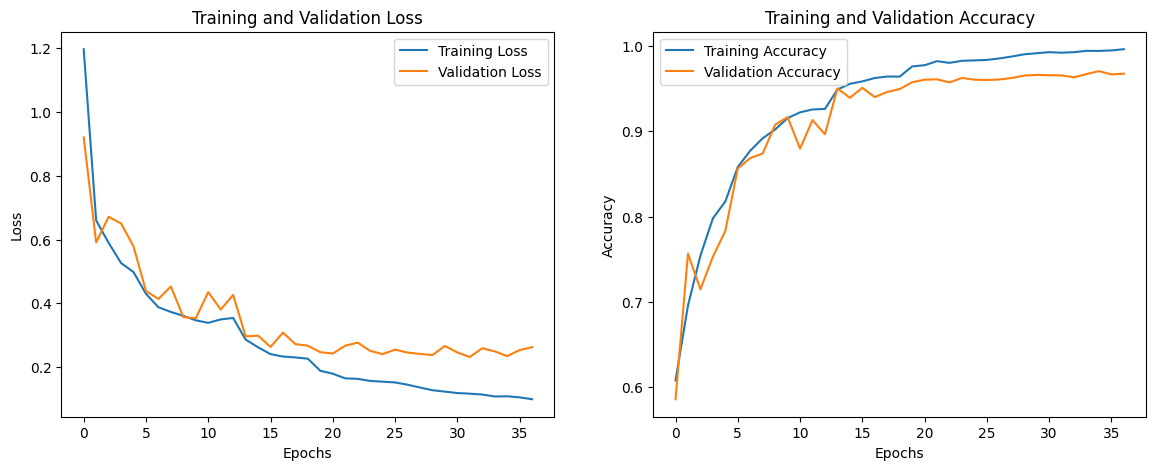

In [12]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training & validation accuracy
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history)

In [ ]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

----------------

## Model Evaluation and Confusion Matrix

- **Model Evaluation**: The model is evaluated on the test data, providing **Test Accuracy** and **Test Loss** metrics.
- **Predictions**: Predictions are generated for the validation dataset, with a threshold of 0.5 to classify them as either "Cat" or "Dog".
- **Confusion Matrix**: A heatmap of the confusion matrix visualizes the model's classification performance, showing true positives, true negatives, false positives, and false negatives.
- The **ROC-AUC Curve** (Receiver Operating Characteristic Curve) evaluates the binary classifier's performance. It compares the **True Positive Rate (TPR)** to the **False Positive Rate (FPR)** at various thresholds and computes the
- **Area Under the Curve (AUC)**, which gives a summary measure of the model's ability to distinguish between classes.





In [3]:
# Load the best model
best_model = load_model('best_model.keras')


## Accuracy

In [19]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(validation_ds, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9716 - loss: 0.2327
Test Accuracy: 97.04%
Test Loss: 0.2344


## extracting true labels from the dataset

In [20]:
preds = model.predict(validation_ds)
pred_labels = (preds > 0.5).astype(int).flatten()

true_labels = []
for _, labels in validation_ds:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


## classification report

In [21]:
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=['Cat', 'Dog']))


Classification Report:
               precision    recall  f1-score   support

         Cat       0.98      0.96      0.97      2500
         Dog       0.96      0.98      0.97      2500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



## Cofusion Matrix

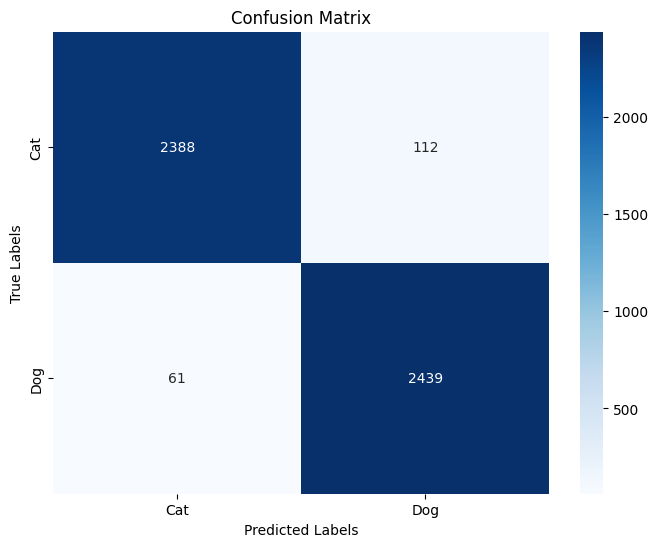

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming true_labels and pred_labels are already defined
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## ROC - AUC Curve

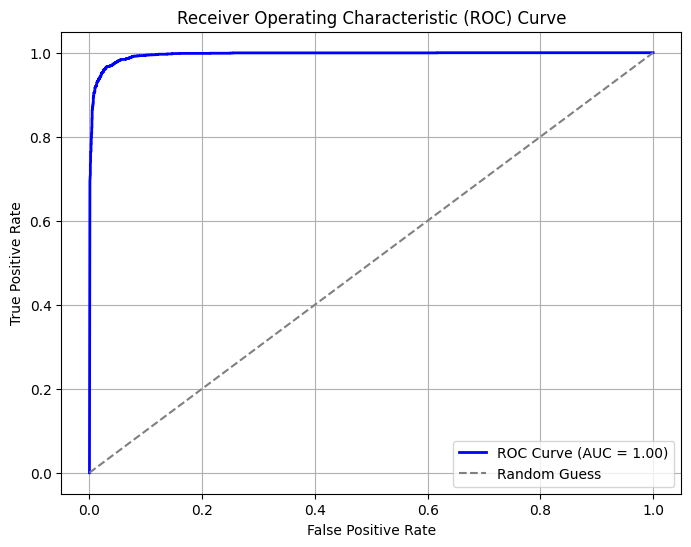

In [23]:

# Compute ROC curve using the true labels and predicted probabilities (preds)
fpr, tpr, thresholds = roc_curve(true_labels, preds.ravel())  
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Insights from Classification Report and Confusion Matrix

### Test Accuracy
- **97% Accuracy**: The model demonstrates strong performance, correctly classifying the majority of test samples.

### Precision
- **Cat**: 0.98  
- **Dog**: 0.96  
  - High precision for both classes indicates the model minimizes false positives effectively (e.g., misclassifying one class as the other).

### Recall
- **Cat**: 0.96  
- **Dog**: 0.98  
  - Slightly better recall for the dog class, meaning the model is better at identifying dog images correctly but still performs very well for cats.

### F1-Score
- **Cat**: 0.97  
- **Dog**: 0.97  
  - Balanced F1-scores show a good trade-off between precision and recall, highlighting the model’s reliable classification capabilitydogs in the dataset.


### Confusion Matrix
- **True Positives**:
  - **Cat**: 2388, **Dog**: 2439
- **False Positives**:
  - **Cat**: 112, **Dog**: 61
- **False Negatives**:
  - **Cat**: 61, **Dog**: 112
- The confusion matrix shows a slight imbalance, with more false positives for the cat class, but it remains relatively minor.

### Summary
- The model performs exceptionally well, with high accuracy and balanced F1-scores for both classes.
- Misclassifications are minimal, with a few more false positives for cats than dogs.



-----

## Testin model on different images from the WEB


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


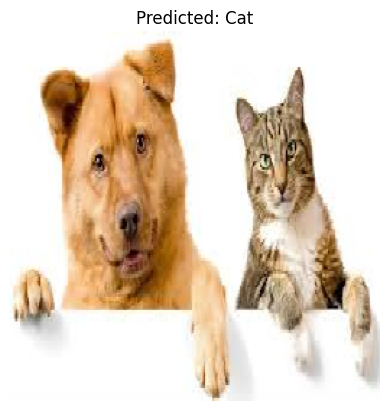

Prediction: Cat


In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Function to preprocess and predict on a single image
def predict_on_image(image_path, model, target_size=(256, 256)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load image
    img_array = img_to_array(img) / 255.0  # Convert to array and normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    preds = model.predict(img_array)
    pred_label = int((preds > 0.5)[0][0])  # Convert probability to binary label

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {'Dog' if pred_label == 1 else 'Cat'}")
    plt.show()

    return pred_label


image_path = "1.jpeg"
predicted_label = predict_on_image(image_path, best_model)
print(f"Prediction: {'Dog' if predicted_label == 1 else 'Cat'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


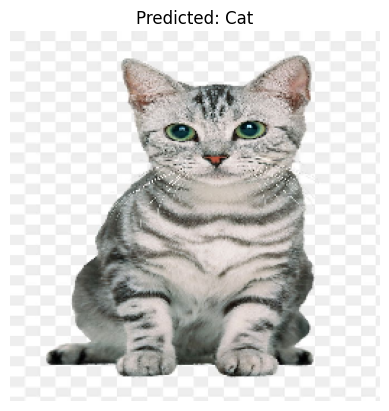

Prediction: 0


In [7]:
# Test the function
image_path = "2.jpeg"  # Replace with your own image path
predicted_label = predict_on_image(image_path, best_model)
print(f"Prediction: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


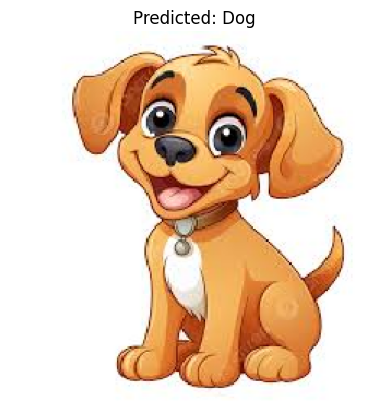

Prediction: 1


In [10]:

# Test the function
image_path = "10.jpeg"  # Replace with your own image path
predicted_label = predict_on_image(image_path, best_model)
print(f"Prediction: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


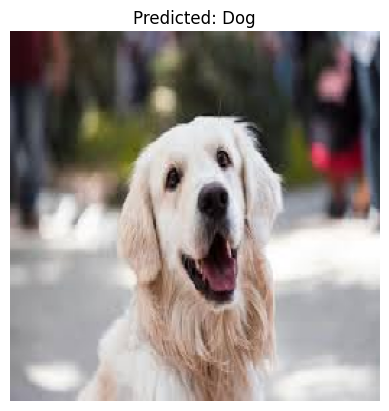

Prediction: 1


In [11]:

# Test the function
image_path = "3.jpeg"  # Replace with your own image path
predicted_label = predict_on_image(image_path, best_model)
print(f"Prediction: {predicted_label}")


------